# Makine Öğrenmesi ile Tahmin

Bu colab dosyasında bir zaman serisini tahmin etmek için bir makine öğrenmesi modeli geliştirelim. İlk olarak basit bir regresyon modeli oluşturacağız sonrasında ise iki katmanlı bir sinir ağı oluşturarak devam edeceğiz. Daha önceden kullandığımız işlevleri ve paketleri içeri aktararak başlayalım.

## Gerekli Tanımlamalar ve Kurulumlar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

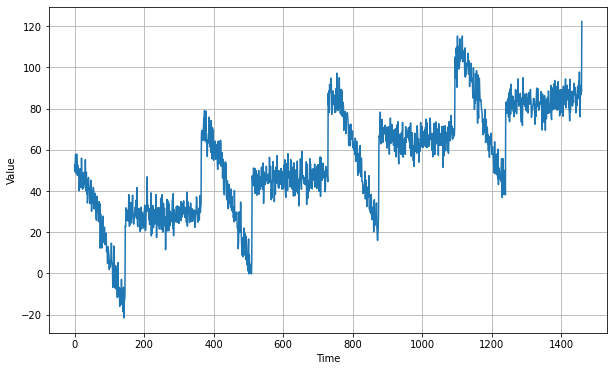

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Pencere Veri Seti Oluşturan İşlevin Tanımlanması

Önceki colav dosyasında oluşturduğumuz gibi bir `window_dataset` işlevi oluşturalım. Bu işlev serileri alır ve makine öğrenmesine uygun girdi setlerine dönüştürür.

İlk olarak, önceki 30 adımdaki verilere bakarak bir sonraki adımı tahmin etmek için bir model eğiteceğiz. Bu nedenle eğitim için 30 adımlık pencerelerden oluşan bir veri seti oluşturmamız gerekiyor.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Doğrusal Model

İlk olarak bir doğrusal model oluşturalım.

-  `keras.backend.clear_session()`: Kerasın arka uç oturumlarını temizler.
- `tf.random.set_seed(42)` ve `np.random.seed(42)` : Kodun her çalıştığında aynı çıktıyı vermesini sağlar = Tekrarlanabilirlik sağlar.

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 3s 9ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - lo

Şimdi oluşturduğumuz modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın `LearningRateScheduler` işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur. 

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(1e-06, 0.001, 0.0, 20.0)

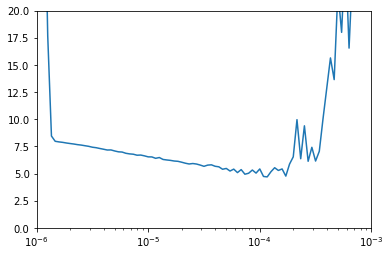

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

Grafiği incelediğimizde en uygun değerin `1e-5` olacağını kabul edebiliriz. `1e-4` değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (epochs) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`.
Aynı zamanda `fit` içerisinde  `callbacks` listesine tanımladığımız erken durdurma işlevini eklememiz gerekecektir.

Ve son olarak `epochs` değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 1s 7ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - lo

Görüldüğü gibi erken durdurma işlevimiz 222. yinelemeden sonra modelimizin eğitimini durdurdu.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (`model_forecast`) oluşturuyoruz.

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Şimdi rahatlıkla tahminlerde bulunabiliriz. Doğrulama verilerimizin bir kısmını parametre olarak vererek tahmnin başarısını gözlemliyelim.

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [12]:
lin_forecast.shape

(461,)

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

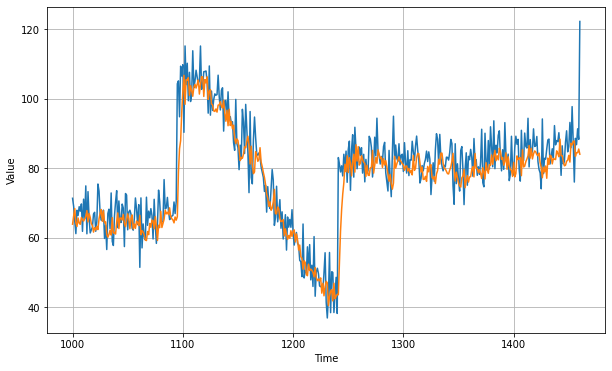

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

Tahminler gerçek değerlere çok iyi olmasa da eşleşiyor gibi görünüyor. Modelimizin performansını ölçelim ve ortalama mutlak hata (`mae`) değerimizi bulalım.

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.166268

## Yoğun (Dense) Modeli ile Tahminlerde Bulunulması

Şimdi de iki katmanlı bir sinir ağı oluşturalım. Doğrusal modelde yaptığımız gibi oluşturduğumuz modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın `LearningRateScheduler` işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur. 

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 35.3203 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 12.6771 - mae: 13.1682
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 8.5974 - mae: 9.0856
Epoch 11/100
31/31 [=====================

En iyi öğrenme değerinin ne olduğuna bakmak için grafiğini çizelim.

(1e-07, 0.005, 0.0, 30.0)

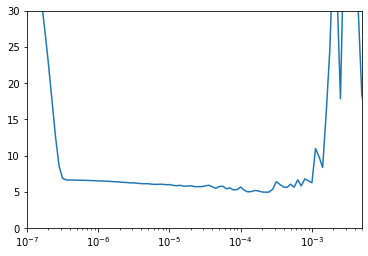

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

Grafiği incelediğimizde en uygun değerin `1e-5` olacağını kabul edebiliriz. `1e-4` değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (epochs) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`.
Aynı zamanda `fit` içerisinde  `callbacks` listesine tanımladığımız erken durdurma işlevini eklememiz gerekecektir.

Ve son olarak `epochs` değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.9028

Görüldüğü gibi erken durdurma işlevimiz 172. yinelemeden sonra modelimizin eğitimini durdurdu.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (`model_forecast`) oluşturmuştuk. `dense_forecast` adında bir değişken oluşturalım ve fonksiyonu çağıralım.

In [18]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

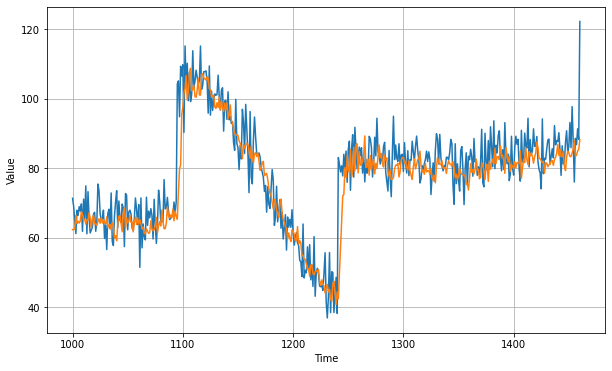

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

Tahminler gerçek değerlere çok iyi olmasa da eşleşiyor gibi görünüyor. Bakalım oluşturduğumuz doğrusal model mi yoksa sinir ağı mı daha iyi performan gösteriyor. Modelimizin performansını ölçelim ve ortalama mutlak hata (`mae`) değerimizi bulalım.

In [20]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.202555